The first step is to compose the training and testing datasets from historical data and computed technical analysis indicators. I will first work with a specific stock, symbol DBV.PA

#### Let's download historical data for the last 10 years from Yahoo! API, and read it in a DataFrame:

In [243]:
!curl -L 'http://query1.finance.yahoo.com/v7/finance/download/DBV.PA?period1=1278160387&period2=1593693187&interval=1d&events=history' > historical_data_DBV-PA.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     8  100     8    0     0     87      0 --:--:-- --:--:-- --:--:--    87
100  132k    0  132k    0     0   636k      0 --:--:-- --:--:-- --:--:--  636k


In [244]:
# install required python packages
!pip install -r requirements.txt

You are using pip version 10.0.1, however version 20.2b1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [245]:
# imports go here
import pandas as pd
import numpy as np
import ta
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [246]:
df = pd.read_csv('historical_data_DBV-PA.csv', index_col=0, parse_dates=True, infer_datetime_format=True)

In [247]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-06-18,7.65,7.90,7.60,7.90,7.90,9379
2012-06-19,7.98,7.98,7.95,7.98,7.98,1451
2012-06-20,7.98,7.98,7.91,7.98,7.98,1060
2012-06-21,7.98,8.06,7.98,8.06,8.06,2739
2012-06-22,8.06,8.12,7.80,8.12,8.12,2960


In [248]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-06-26,9.600,9.60,7.950,8.260,8.260,1582062
2020-06-29,8.275,8.70,8.165,8.190,8.190,405154
2020-06-30,8.320,8.42,7.830,7.875,7.875,368269
2020-07-01,7.890,8.29,7.830,8.105,8.105,514745
2020-07-02,8.205,8.29,7.985,8.080,8.080,254322


#### Display descriptive stats about the dataset:

In [249]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,2054.000000,2054.000000,2054.000000,2054.000000,2054.000000,2.054000e+03
mean,33.849825,34.402337,33.236986,33.811760,33.811760,1.072788e+05
std,22.630417,22.930311,22.283141,22.607351,22.607351,2.194790e+05
min,3.610000,6.310000,3.500000,4.100000,4.100000,0.000000e+00
25%,12.875000,13.277500,12.637500,12.900000,12.900000,1.803900e+04
50%,32.020001,32.620001,31.290000,31.940000,31.940000,4.469150e+04
75%,55.919999,57.647501,54.810000,56.022499,56.022499,1.077190e+05
max,84.000000,86.639999,83.089996,83.510002,83.510002,3.212717e+06


#### Plot the distributions of our features:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe5c4fc3390>,
      dtype=object)

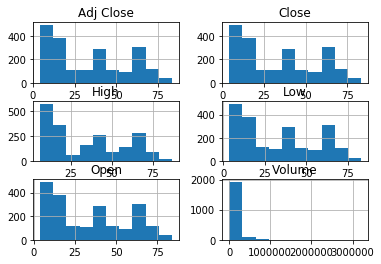

In [250]:
df.hist()

#### Are there any NaN values in the dataset?

In [251]:
df.isna().sum().sum()

0

#### Let's add technical analysis indicators to our feature set.  
I will use the 'ta' python package to compute them:

In [252]:
df = ta.add_all_ta_features(df, open='Open', high='High', low='Low', close='Close', volume='Volume')

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ta/trend.py:608: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i]/self._trs[i])
/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/ta/trend.py:612: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i]/self._trs[i])


In [253]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_uo,momentum_stoch,momentum_stoch_signal,momentum_wr,momentum_ao,momentum_kama,momentum_roc,others_dr,others_dlr,others_cr
Date,,,,,,,,,,,,,,,,,,,,,
2012-06-18,7.65,7.90,7.60,7.90,7.90,9379,9379.0,9379,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-76.635348,NaN,0.000000
2012-06-19,7.98,7.98,7.95,7.98,7.98,1451,10830.0,10830,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.012658,1.007565,1.012658
2012-06-20,7.98,7.98,7.91,7.98,7.98,1060,11890.0,11890,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.012658
2012-06-21,7.98,8.06,7.98,8.06,8.06,2739,14629.0,14629,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.002506,0.997515,2.025316
2012-06-22,8.06,8.12,7.80,8.12,8.12,2960,17589.0,17589,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.744417,0.741660,2.784810


In [254]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'volume_adi',
       'volume_obv', 'volume_cmf', 'volume_fi', 'momentum_mfi', 'volume_em',
       'volume_sma_em', 'volume_vpt', 'volume_nvi', 'volume_vwap',
       'volatility_atr', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow', 'trend_adx',
       'trend_adx_pos', 'trend_adx_neg', 'trend_vortex_ind_pos',
       'trend_vortex_ind_neg', 'trend_vortex_ind_diff', 'trend_trix',
       'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ic

#### The dataset now has much more features, but also NaN values. I will then perform interpolation of the dataset, so that they get replaced by neutral values, i.e. that will not influence the algorithm during training:

In [255]:
df.isna().sum().sum()

3007

In [256]:
df.interpolate(axis=0, limit_direction='both', inplace=True)

In [257]:
df.isna().sum().sum()

0

#### I will now add historical data for CAC40 and SBF120, the indices that DBV.PA stock relates to:

In [258]:
!curl -L 'http://query1.finance.yahoo.com/v7/finance/download/^FCHI?period1=1340022787&period2=1593693187&interval=1d&events=history' > historical_data_CAC40.csv
!curl -L 'http://query1.finance.yahoo.com/v7/finance/download/^SBF120?period1=1340022787&period2=1593693187&interval=1d&events=history' > historical_data_SBF120.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     8  100     8    0     0    222      0 --:--:-- --:--:-- --:--:--   222
100  161k    0  161k    0     0  1054k      0 --:--:-- --:--:-- --:--:-- 1054k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100     8  100     8    0     0    242      0 --:--:-- --:--:-- --:--:--   242
100  110k    0  110k    0     0   771k      0 --:--:-- --:--:-- --:--:--  771k


In [259]:
# Prefix columns with index name

cac40_df = pd.read_csv('historical_data_CAC40.csv', index_col=0, parse_dates=True, infer_datetime_format=True)
sbf120_df = pd.read_csv('historical_data_SBF120.csv', index_col=0, parse_dates=True, infer_datetime_format=True)

prefixed_cac_cols = list()
prefixed_sbf_cols = list()
for cac_col, sbf_col in zip(cac40_df.columns, sbf120_df.columns):
    prefixed_cac_cols.append('cac40_' + cac_col)
    prefixed_sbf_cols.append('sbf120_' + sbf_col)

cac40_df.columns = prefixed_cac_cols
sbf120_df.columns = prefixed_sbf_cols

In [260]:
# Check everything went as expected

print(cac40_df.columns)
print(sbf120_df.columns)

Index(['cac40_Open', 'cac40_High', 'cac40_Low', 'cac40_Close',
       'cac40_Adj Close', 'cac40_Volume'],
      dtype='object')
Index(['sbf120_Open', 'sbf120_High', 'sbf120_Low', 'sbf120_Close',
       'sbf120_Adj Close', 'sbf120_Volume'],
      dtype='object')


In [261]:
# Interpolate both dataframes to fill NaNs
cac40_df.interpolate(axis=0, limit_direction='both', inplace=True)
sbf120_df.interpolate(axis=0, limit_direction='both', inplace=True)

In [262]:
# Add These features to our stock price dataset
df = pd.concat([df, cac40_df], axis=1)

In [263]:
df = pd.concat([df, sbf120_df], axis=1)

In [264]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,cac40_Low,cac40_Close,cac40_Adj Close,cac40_Volume,sbf120_Open,sbf120_High,sbf120_Low,sbf120_Close,sbf120_Adj Close,sbf120_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2012-06-18,7.65,7.90,7.60,7.90,7.90,9379,9379.0,9379,0.54337,220.458406,...,3054.379883,3066.189941,3066.189941,207724400.0,2358.310059,2358.310059,2358.310059,2358.310059,2358.310059,0.0
2012-06-19,7.98,7.98,7.95,7.98,7.98,1451,10830.0,10830,0.54337,220.458406,...,3052.649902,3117.919922,3117.919922,169850800.0,2396.639893,2396.639893,2396.639893,2396.639893,2396.639893,0.0
2012-06-20,7.98,7.98,7.91,7.98,7.98,1060,11890.0,11890,0.54337,220.458406,...,3100.510010,3126.520020,3126.520020,145760000.0,2404.429932,2404.429932,2404.429932,2404.429932,2404.429932,0.0
2012-06-21,7.98,8.06,7.98,8.06,8.06,2739,14629.0,14629,0.54337,220.458406,...,3099.739990,3114.219971,3114.219971,171797000.0,2394.449951,2394.449951,2394.449951,2394.449951,2394.449951,0.0
2012-06-22,8.06,8.12,7.80,8.12,8.12,2960,17589.0,17589,0.54337,220.458406,...,3075.139893,3090.899902,3090.899902,139216800.0,2374.939941,2374.939941,2374.939941,2374.939941,2374.939941,0.0


#### The value I am trying to predict is Ajdusted Close for day d + 1 to 7, from stock characteristics of day d. This means I have to shift the Adjusted Close column by -1 to -7, and drop the last 7 rows:

In [265]:
adjclose_df = pd.DataFrame()
adjclose_cols = list()
for i in range(1, 8):
    colname = 'AdjClose_D+' + str(i)
    adjclose_df[colname] = df['Adj Close'].shift(periods=-i)
    adjclose_cols.append(colname)
adjclose_df.columns = adjclose_cols

In [268]:
adjclose_df.tail()

,AdjClose_D+1,AdjClose_D+2,AdjClose_D+3,AdjClose_D+4,AdjClose_D+5,AdjClose_D+6,AdjClose_D+7
Date,,,,,,,
2020-06-26,8.190,7.875,8.105,8.08,NaN,NaN,NaN
2020-06-29,7.875,8.105,8.080,NaN,NaN,NaN,NaN
2020-06-30,8.105,8.080,NaN,NaN,NaN,NaN,NaN
2020-07-01,8.080,NaN,NaN,NaN,NaN,NaN,NaN
2020-07-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [269]:
adjclose_df.drop(adjclose_df.tail(i).index,inplace=True)

In [271]:
df.drop(df.tail(i).index,inplace=True)

In [270]:
adjclose_df.tail()

,AdjClose_D+1,AdjClose_D+2,AdjClose_D+3,AdjClose_D+4,AdjClose_D+5,AdjClose_D+6,AdjClose_D+7
Date,,,,,,,
2020-06-17,9.790,9.895,9.76,10.28,9.770,9.720,8.260
2020-06-18,9.895,9.760,10.28,9.77,9.720,8.260,8.190
2020-06-19,9.760,10.280,9.77,9.72,8.260,8.190,7.875
2020-06-22,10.280,9.770,9.72,8.26,8.190,7.875,8.105
2020-06-23,9.770,9.720,8.26,8.19,7.875,8.105,8.080


In [280]:
adjclose_df.head()

,AdjClose_D+1,AdjClose_D+2,AdjClose_D+3,AdjClose_D+4,AdjClose_D+5,AdjClose_D+6,AdjClose_D+7
Date,,,,,,,
2012-06-18,7.98,7.98,8.06,8.12,8.45,8.49,8.40
2012-06-19,7.98,8.06,8.12,8.45,8.49,8.40,8.50
2012-06-20,8.06,8.12,8.45,8.49,8.40,8.50,8.89
2012-06-21,8.12,8.45,8.49,8.40,8.50,8.89,8.90
2012-06-22,8.45,8.49,8.40,8.50,8.89,8.90,8.89


In [281]:
adjclose_df.shape

(2047, 7)

In [272]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,cac40_Low,cac40_Close,cac40_Adj Close,cac40_Volume,sbf120_Open,sbf120_High,sbf120_Low,sbf120_Close,sbf120_Adj Close,sbf120_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2020-06-17,9.995,10.17,9.790,9.950,9.950,241871,-1.791313e+07,11707227,-0.017978,53137.834230,...,4952.569824,4995.970215,4995.970215,107060900.0,3648.330078,3648.330078,3648.330078,3648.330078,3648.330078,0.0
2020-06-18,9.820,10.02,9.625,9.790,9.790,186896,-1.794389e+07,11520331,-0.006729,41274.806483,...,4908.600098,4958.750000,4958.750000,101195000.0,3648.330078,3648.330078,3648.330078,3648.330078,3648.330078,0.0
2020-06-19,9.980,10.27,9.845,9.895,9.895,257997,-1.814118e+07,11778328,-0.068238,39248.360557,...,4979.450195,4979.450195,4979.450195,219575400.0,3648.330078,3648.330078,3648.330078,3648.330078,3648.330078,0.0
2020-06-22,9.820,10.04,9.585,9.760,9.760,255969,-1.820025e+07,11522359,-0.069018,28704.906906,...,4902.060059,4948.700195,4948.700195,84695500.0,3648.330078,3648.330078,3648.330078,3648.330078,3648.330078,0.0
2020-06-23,9.990,10.76,9.855,10.280,10.280,591859,-1.823622e+07,12114218,-0.047884,68570.874491,...,4962.600098,5017.680176,5017.680176,101534900.0,3648.330078,3648.330078,3648.330078,3648.330078,3648.330078,0.0


In [282]:
df.head()

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,cac40_Low,cac40_Close,cac40_Adj Close,cac40_Volume,sbf120_Open,sbf120_High,sbf120_Low,sbf120_Close,sbf120_Adj Close,sbf120_Volume
Date,,,,,,,,,,,,,,,,,,,,,
2012-06-18,7.65,7.90,7.60,7.90,7.90,9379,9379.0,9379,0.54337,220.458406,...,3054.379883,3066.189941,3066.189941,207724400.0,2358.310059,2358.310059,2358.310059,2358.310059,2358.310059,0.0
2012-06-19,7.98,7.98,7.95,7.98,7.98,1451,10830.0,10830,0.54337,220.458406,...,3052.649902,3117.919922,3117.919922,169850800.0,2396.639893,2396.639893,2396.639893,2396.639893,2396.639893,0.0
2012-06-20,7.98,7.98,7.91,7.98,7.98,1060,11890.0,11890,0.54337,220.458406,...,3100.510010,3126.520020,3126.520020,145760000.0,2404.429932,2404.429932,2404.429932,2404.429932,2404.429932,0.0
2012-06-21,7.98,8.06,7.98,8.06,8.06,2739,14629.0,14629,0.54337,220.458406,...,3099.739990,3114.219971,3114.219971,171797000.0,2394.449951,2394.449951,2394.449951,2394.449951,2394.449951,0.0
2012-06-22,8.06,8.12,7.80,8.12,8.12,2960,17589.0,17589,0.54337,220.458406,...,3075.139893,3090.899902,3090.899902,139216800.0,2374.939941,2374.939941,2374.939941,2374.939941,2374.939941,0.0


In [283]:
df.shape

(2047, 90)

#### I will then train 7 models, each predicting a different Adjusted Close value for D + 1 up to 7:

#### The dataset has very different value ranges, so I have to normalize it:

In [273]:
X_scaler = MinMaxScaler().fit(df.values)
y_scaler = MinMaxScaler().fit(adjclose_df.values)

X_scaled = X_scaler.transform(df.values)
y_scaled = y_scaler.transform(adjclose_df.values)

#### Split training and testing sets:

In [274]:
# the last 15% data go to the testing set
train_size = int(len(X_scaled) * 0.85)
train_X, test_X = X_scaled[0:train_size], X_scaled[train_size:len(X_scaled)]
train_y, test_y = y_scaled[0:train_size], y_scaled[train_size:len(y)]

In [275]:
# Check if split is correct
print("training set size: {:.2f}%".format(len(train_X)/len(X) * 100))
print("testing set size: {:.2f}%".format(len(test_X)/len(X) * 100))

training set size: 84.71%
testing set size: 15.00%


#### As the dataset is small, with a lot of features, I will try RandomForestRegressor:

In [299]:
def sd_rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred)) / np.std(y_true)

In [301]:
model_list = list()
preds_list = list()
for i in range(7):
    model_list.append(RandomForestRegressor(n_estimators=400, random_state=42))
    model_list[i].fit(train_X, train_y[:,i])
    preds_list.append(model_list[i].predict(test_X))
    print("SD-RMSE for D+{}: {:.4f}".format(i + 1, sd_rmse(test_y[:,i], preds_list[i])))

SD-RMSE for D+1: 0.2259
SD-RMSE for D+2: 0.3353
SD-RMSE for D+3: 0.4543
SD-RMSE for D+4: 0.5246
SD-RMSE for D+5: 0.5994
SD-RMSE for D+6: 0.6951
SD-RMSE for D+7: 0.7022


#### The SD-RMSE value of 0.4 means that the trained model can explain a good part of the variance of the testing dataset.  I will now group all data preprocessing into a single function, so that it is possible to make predictions:

In [302]:
# A value can be translated from scaled data to real-world value with X_scaler.inverse_transform(scaled_preds_y)

[array([0.15344357, 0.15111106, 0.15158681, 0.15126576, 0.15137908,
        0.15080977, 0.14879967, 0.14666725, 0.14889881, 0.15205795,
        0.16394328, 0.17249767, 0.18566391, 0.16751889, 0.16226652,
        0.17296732, 0.16387719, 0.1668783 , 0.16455187, 0.15429206,
        0.15119258, 0.14852731, 0.15089752, 0.15332747, 0.15874432,
        0.15481735, 0.15087976, 0.15543059, 0.15634125, 0.15360023,
        0.15238362, 0.15785256, 0.15782211, 0.15519124, 0.15474545,
        0.15332291, 0.15193095, 0.15211397, 0.15453959, 0.15525851,
        0.15195895, 0.15293109, 0.15100972, 0.14158999, 0.14009537,
        0.14012403, 0.130531  , 0.13983894, 0.14489474, 0.14513618,
        0.13932247, 0.13901261, 0.13058518, 0.1276965 , 0.12972321,
        0.14142205, 0.14821075, 0.15058033, 0.15183024, 0.19166709,
        0.19277126, 0.18796706, 0.17909199, 0.19098192, 0.19467004,
        0.18201445, 0.18253582, 0.18183438, 0.16758063, 0.16924271,
        0.18108028, 0.18074864, 0.18294836, 0.18